# テンソル多体分解の実装

In [1]:
import numpy as np
import scipy
import itertools
from scipy.special import logsumexp


def kl(P, Q):
    return np.sum(P * np.log(P / Q)) - np.sum(P) + np.sum(Q)


def get_eta(Q, D):
    for i in range(D):
        Q = np.flip(np.cumsum(np.flip(Q, axis=i), axis=i), axis=i)
    return Q


def get_h(theta, D):
    for i in range(D):
        theta = np.cumsum(theta, axis=i)
    return theta


def MBTA(
    X,
    B=None,
    order=2,
    n_iter=10,
    lr=1.0,
    eps=1.0e-5,
    error_tol=1.0e-5,
    ngd=True,
    verbose=True,
):
    all_history_kl = []
    D = len(X.shape)
    S = X.shape

    if B is None:

        def constraint(I):
            I = np.array(I)
            if np.sum(I != 0) <= order:
                return True
            else:
                return False

        B = [
            I
            for I in itertools.product(*[list(range(S[d])) for d in range(D)])
            if constraint(I)
        ]

    scaleX = np.sum(X + eps)
    P = (X + eps) / scaleX

    Q = np.ones(P.shape)
    Q = Q / np.sum(Q)
    ### eta
    eta_hat = get_eta(P, D)
    eta_hat_b = np.empty((len(B),))
    for u, I in enumerate(B):
        eta_hat_b[u] = eta_hat[I]
    ###
    eta_b = np.empty((len(B),))
    theta_b = np.zeros((len(B),))
    G = np.zeros((len(B), len(B)))
    history_kl = []
    prev_kld = None
    # evaluation
    kld = kl(P, Q)
    history_kl.append(kld)
    if verbose:
        print("iter=", 0, "kl=", kld, "mse=", np.mean((P - Q) ** 2))
    for i in range(n_iter):
        # compute eta
        eta = get_eta(Q, D)
        for u, I in enumerate(B):
            eta_b[u] = eta[tuple(I)]

        # compute G
        for u, I in enumerate(B):
            for v in range(u + 1):
                J = B[v]
                I_ = np.array(I)
                J_ = np.array(J)
                K_ = np.maximum(I_, J_)
                G[u, v] = eta[tuple(K_)] - eta[I] * eta[J]

        # update theta_b
        if ngd:
            # theta_b[1:] -= lr*np.linalg.pinv(G[1:,1:])@(eta_b[1:]-eta_hat_b[1:])
            v = scipy.linalg.solve(
                G[1:, 1:], lr * (eta_b[1:] - eta_hat_b[1:]), lower=True, assume_a="sym"
            )
            theta_b[1:] -= v
        else:
            theta_b -= lr * (eta_b - eta_hat_b)
        # theta_b=>theta
        theta = np.zeros(S)
        for u, I in enumerate(B):
            theta[I] = theta_b[u]
        # theta => H => Q
        Hq = get_h(theta, D)

        # without logsum exp
        # Q_=np.exp(Hq)
        # Q=(Q_+eps)/np.sum(Q_+eps)

        # with logsumexp
        logQ_ = Hq
        logQ = logQ_ - logsumexp(logQ_)
        Q = np.exp(logQ) + eps

        # evaluation
        kld = kl(P, Q)
        history_kl.append(kld)
        if verbose:
            print("iter=", i + 1, "kl=", kld, "mse=", np.mean((P - Q) ** 2))
        if prev_kld is not None and prev_kld - kld < error_tol:
            break
        prev_kld = kld

    all_history_kl.append(history_kl)
    return all_history_kl, scaleX, Q, theta

# 実験

## Randomテンソルによる実験

### ２次近似

In [ ]:
N = 10
X = np.random.uniform(0, 0.1, size=(N, N, N, N))
X

array([[[[6.17419050e-03, 7.04205365e-02, 6.45523859e-02, ...,
          8.61972830e-02, 2.37817956e-02, 3.47759322e-03],
         [4.25187961e-02, 2.04523995e-02, 5.03656589e-02, ...,
          9.31832897e-02, 9.51956611e-02, 5.79101311e-02],
         [4.91750424e-02, 9.38663470e-02, 4.71759435e-02, ...,
          7.84829937e-02, 6.52559155e-02, 8.75728873e-02],
         ...,
         [7.79469836e-02, 3.77987802e-02, 5.65465291e-03, ...,
          9.19372501e-03, 9.13819826e-02, 8.71857781e-02],
         [2.81255186e-02, 3.56806969e-02, 1.35634926e-03, ...,
          8.74477954e-02, 7.93648105e-02, 7.83651087e-02],
         [6.03620848e-02, 1.91031086e-02, 5.96813048e-02, ...,
          3.19993112e-02, 7.07432687e-02, 4.05021041e-02]],

        [[1.70371961e-03, 2.44919848e-02, 4.02559221e-02, ...,
          6.90498516e-02, 3.86150491e-02, 2.11781758e-02],
         [2.84420430e-02, 7.54559323e-02, 7.82778330e-02, ...,
          7.21481443e-02, 3.71211300e-02, 3.71735866e-02],
        

In [ ]:
print(X.shape)
all_history_kl, scaleX, Q, Hq = MBTA(X, order=2)

(10, 10, 10, 10)
iter= 0 kl= 0.19753049352995822 mse= 3.4118674048648243e-09
iter= 1 kl= 0.19157736730557362 mse= 3.300560388134946e-09
iter= 2 kl= 0.19198403220876215 mse= 3.3149568786142335e-09


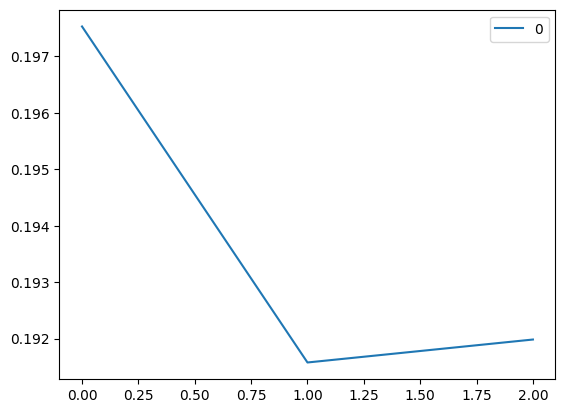

In [ ]:
import matplotlib.pyplot as plt

for k, history_kl in enumerate(all_history_kl):
    plt.plot(history_kl, label="{}".format(k))
plt.legend()

## 画像テンソルによる実験

### 2次近似

In [ ]:
# 画像データ
! wget http://www.cs.columbia.edu/CAVE/databases/SLAM_coil-20_coil-100/coil-100/coil-100.zip
!unzip coil-100.zip

ストリーミング出力は最後の 5000 行に切り捨てられました。
  inflating: coil-100/obj37__275.png  
 extracting: coil-100/obj37__280.png  
  inflating: coil-100/obj37__285.png  
  inflating: coil-100/obj37__290.png  
  inflating: coil-100/obj37__295.png  
  inflating: coil-100/obj37__30.png  
  inflating: coil-100/obj37__300.png  
  inflating: coil-100/obj37__305.png  
  inflating: coil-100/obj37__310.png  
  inflating: coil-100/obj37__315.png  
  inflating: coil-100/obj37__320.png  
  inflating: coil-100/obj37__325.png  
  inflating: coil-100/obj37__330.png  
  inflating: coil-100/obj37__335.png  
  inflating: coil-100/obj37__340.png  
  inflating: coil-100/obj37__345.png  
  inflating: coil-100/obj37__35.png  
  inflating: coil-100/obj37__350.png  
  inflating: coil-100/obj37__355.png  
  inflating: coil-100/obj37__40.png  
  inflating: coil-100/obj37__45.png  
  inflating: coil-100/obj37__5.png   
  inflating: coil-100/obj37__50.png  
  inflating: coil-100/obj37__55.png  
  inflating: coil-100/obj37__60.png  
 

(32, 32, 3)


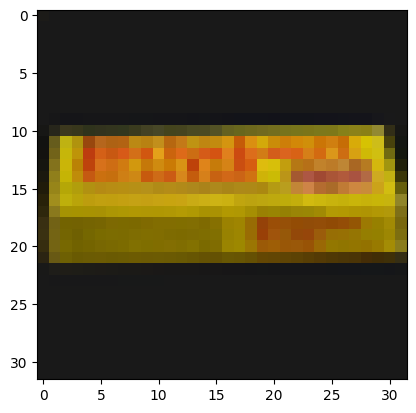

(32, 32, 3)


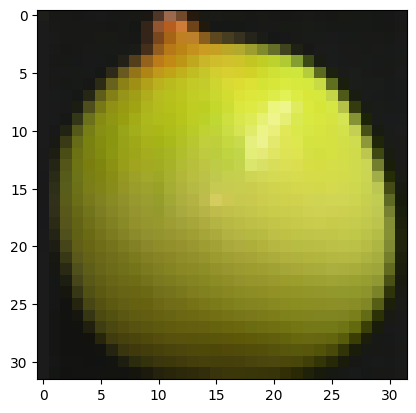

(32, 32, 3)


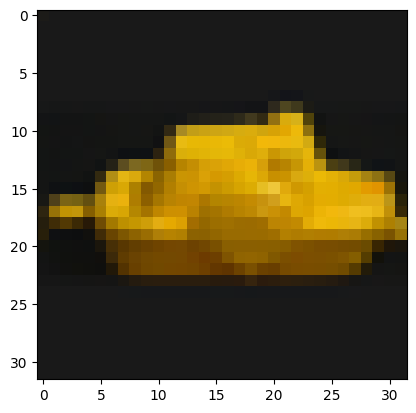

(32, 32, 3)


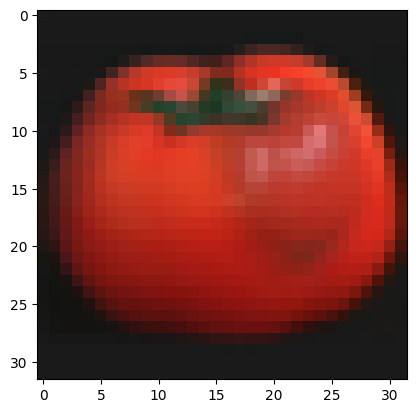

(4, 32, 32, 3)

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

X = []
for k in range(1, 5):
    # ファイル名、パス
    file_name = "coil-100/obj{}__0.png".format(k)
    img = Image.open(file_name)
    img = img.resize((32, 32))
    array_obj = np.asarray(img)
    print(array_obj.shape)
    # 画像の表示
    plt.imshow(array_obj)
    plt.show()
    X.append(array_obj)
X = np.array(X)
X = (X + 1) / 256.0
X.shape

In [ ]:
print(X.shape)
all_history_kl, scaleX, Q, Hq = MBTA(X, order=2)

(4, 32, 32, 3)
iter= 0 kl= 0.40933036749812957 mse= 6.547791436815624e-09
iter= 1 kl= 0.10298763093803354 mse= 4.315431361739226e-09
iter= 2 kl= 0.059935711890076515 mse= 1.2021983416556761e-09
iter= 3 kl= 0.056726426653199935 mse= 9.041612448785827e-10
iter= 4 kl= 0.05637659105749293 mse= 8.625459326492408e-10
iter= 5 kl= 0.05630926475531228 mse= 8.553732950321913e-10
iter= 6 kl= 0.05628995029188277 mse= 8.539528474251786e-10
iter= 7 kl= 0.0562828947444558 mse= 8.536284408412882e-10


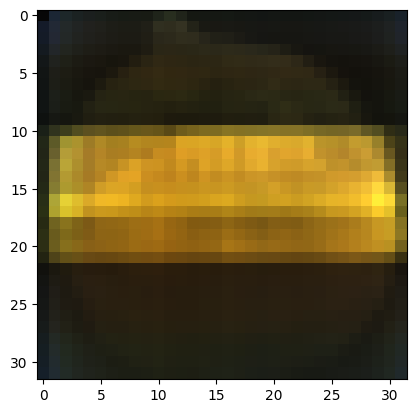

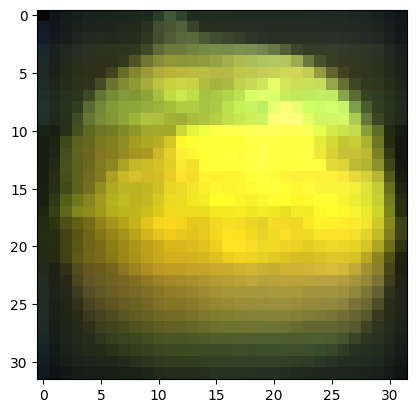

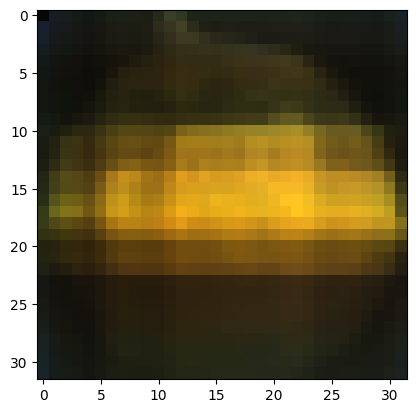

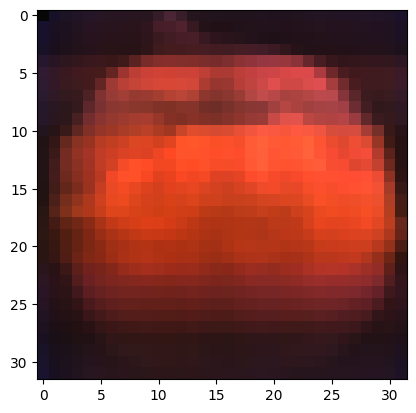

In [ ]:
# 前処理の逆変換
X_recons = (Q * scaleX * 256).astype(np.int32)

for i in range(len(X_recons)):
    plt.imshow(X_recons[i])
    plt.show()

### リング分解による実装

In [ ]:
# ring decomposition
def constraint(I):
    I = np.array(I)
    idx = np.where(I)[0]
    if len(idx) == 2:
        if idx[1] - idx[0] == 1 or (idx[1] == 3 and idx[0] == 0):
            return True
        else:
            return False
    else:
        return False


B = [
    I
    for I in itertools.product(*[list(range(X.shape[d])) for d in range(len(X.shape))])
    if constraint(I)
]
B

[(0, 0, 1, 1),
 (0, 0, 1, 2),
 (0, 0, 2, 1),
 (0, 0, 2, 2),
 (0, 0, 3, 1),
 (0, 0, 3, 2),
 (0, 0, 4, 1),
 (0, 0, 4, 2),
 (0, 0, 5, 1),
 (0, 0, 5, 2),
 (0, 0, 6, 1),
 (0, 0, 6, 2),
 (0, 0, 7, 1),
 (0, 0, 7, 2),
 (0, 0, 8, 1),
 (0, 0, 8, 2),
 (0, 0, 9, 1),
 (0, 0, 9, 2),
 (0, 0, 10, 1),
 (0, 0, 10, 2),
 (0, 0, 11, 1),
 (0, 0, 11, 2),
 (0, 0, 12, 1),
 (0, 0, 12, 2),
 (0, 0, 13, 1),
 (0, 0, 13, 2),
 (0, 0, 14, 1),
 (0, 0, 14, 2),
 (0, 0, 15, 1),
 (0, 0, 15, 2),
 (0, 0, 16, 1),
 (0, 0, 16, 2),
 (0, 0, 17, 1),
 (0, 0, 17, 2),
 (0, 0, 18, 1),
 (0, 0, 18, 2),
 (0, 0, 19, 1),
 (0, 0, 19, 2),
 (0, 0, 20, 1),
 (0, 0, 20, 2),
 (0, 0, 21, 1),
 (0, 0, 21, 2),
 (0, 0, 22, 1),
 (0, 0, 22, 2),
 (0, 0, 23, 1),
 (0, 0, 23, 2),
 (0, 0, 24, 1),
 (0, 0, 24, 2),
 (0, 0, 25, 1),
 (0, 0, 25, 2),
 (0, 0, 26, 1),
 (0, 0, 26, 2),
 (0, 0, 27, 1),
 (0, 0, 27, 2),
 (0, 0, 28, 1),
 (0, 0, 28, 2),
 (0, 0, 29, 1),
 (0, 0, 29, 2),
 (0, 0, 30, 1),
 (0, 0, 30, 2),
 (0, 0, 31, 1),
 (0, 0, 31, 2),
 (0, 1, 1, 0),
 (0, 1, 2, 

In [ ]:
all_history_kl, scaleX, Q, Hq = MBTA(X, B)

iter= 0 kl= 0.40933036749812957 mse= 6.547791436815624e-09
iter= 1 kl= 0.10524330244727564 mse= 1.8355928689278859e-09
iter= 2 kl= 0.0836841410132354 mse= 1.104983516744008e-09
iter= 3 kl= 0.08538042753311204 mse= 1.0506821164388465e-09


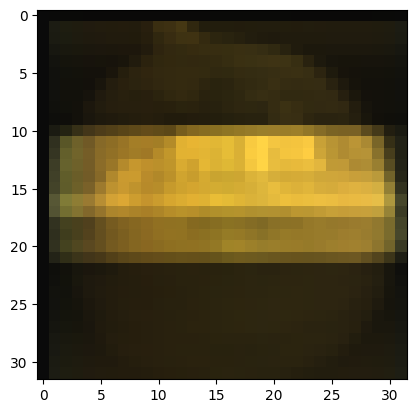

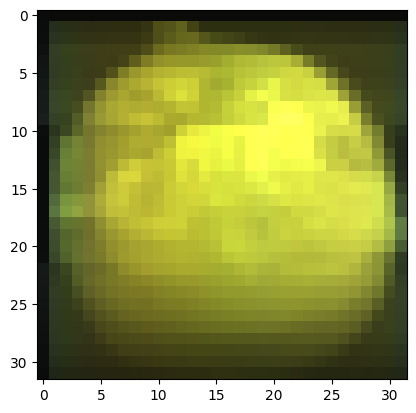

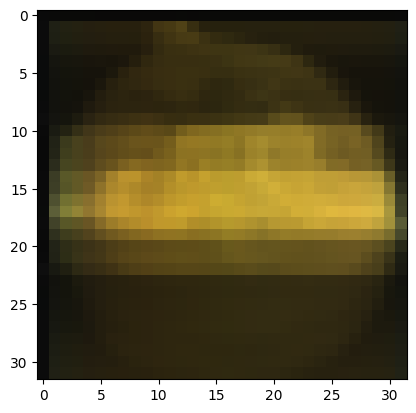

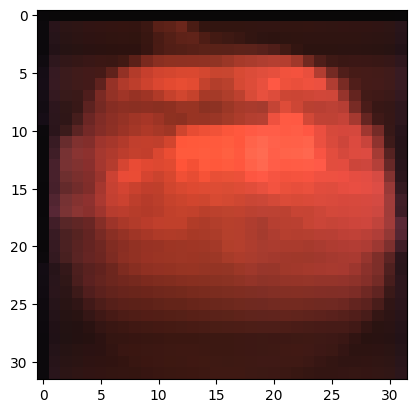

In [ ]:
X_recons = (Q * scaleX * 256).astype(np.int32)

for i in range(len(X_recons)):
    plt.imshow(X_recons[i])
    plt.show()

### 依存関係Bを設計

In [ ]:
# ２次の近似から、index - channel 結合を切断する
def constraint(I):
    I = np.array(I)
    if np.sum(I != 0) <= 2:
        if I[0] != 0 and I[3] != 0:
            return False
        else:
            return True
    else:
        return False


B = [
    I
    for I in itertools.product(*[list(range(X.shape[d])) for d in range(len(X.shape))])
    if constraint(I)
]
B

[(0, 0, 0, 0),
 (0, 0, 0, 1),
 (0, 0, 0, 2),
 (0, 0, 1, 0),
 (0, 0, 1, 1),
 (0, 0, 1, 2),
 (0, 0, 2, 0),
 (0, 0, 2, 1),
 (0, 0, 2, 2),
 (0, 0, 3, 0),
 (0, 0, 3, 1),
 (0, 0, 3, 2),
 (0, 0, 4, 0),
 (0, 0, 4, 1),
 (0, 0, 4, 2),
 (0, 0, 5, 0),
 (0, 0, 5, 1),
 (0, 0, 5, 2),
 (0, 0, 6, 0),
 (0, 0, 6, 1),
 (0, 0, 6, 2),
 (0, 0, 7, 0),
 (0, 0, 7, 1),
 (0, 0, 7, 2),
 (0, 0, 8, 0),
 (0, 0, 8, 1),
 (0, 0, 8, 2),
 (0, 0, 9, 0),
 (0, 0, 9, 1),
 (0, 0, 9, 2),
 (0, 0, 10, 0),
 (0, 0, 10, 1),
 (0, 0, 10, 2),
 (0, 0, 11, 0),
 (0, 0, 11, 1),
 (0, 0, 11, 2),
 (0, 0, 12, 0),
 (0, 0, 12, 1),
 (0, 0, 12, 2),
 (0, 0, 13, 0),
 (0, 0, 13, 1),
 (0, 0, 13, 2),
 (0, 0, 14, 0),
 (0, 0, 14, 1),
 (0, 0, 14, 2),
 (0, 0, 15, 0),
 (0, 0, 15, 1),
 (0, 0, 15, 2),
 (0, 0, 16, 0),
 (0, 0, 16, 1),
 (0, 0, 16, 2),
 (0, 0, 17, 0),
 (0, 0, 17, 1),
 (0, 0, 17, 2),
 (0, 0, 18, 0),
 (0, 0, 18, 1),
 (0, 0, 18, 2),
 (0, 0, 19, 0),
 (0, 0, 19, 1),
 (0, 0, 19, 2),
 (0, 0, 20, 0),
 (0, 0, 20, 1),
 (0, 0, 20, 2),
 (0, 0, 21, 0),
 (0, 0

In [ ]:
all_history_kl, scaleX, Q, Hq = MBTA(X, B)

iter= 0 kl= 0.40933036749812957 mse= 6.547791436815624e-09
iter= 1 kl= 0.12076595738117102 mse= 5.106540659741128e-09
iter= 2 kl= 0.07689575680737892 mse= 1.6681203214127134e-09
iter= 3 kl= 0.0741365757800736 mse= 1.351886006919463e-09
iter= 4 kl= 0.07392772955421556 mse= 1.3097432250431113e-09
iter= 5 kl= 0.0739145232133176 mse= 1.3031207637134506e-09
iter= 6 kl= 0.07391942040049093 mse= 1.3020474635413034e-09


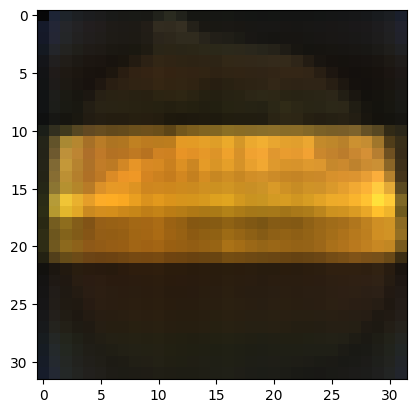

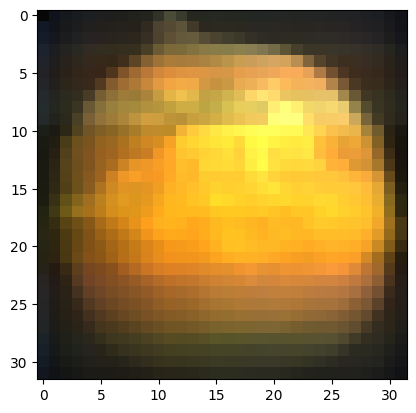

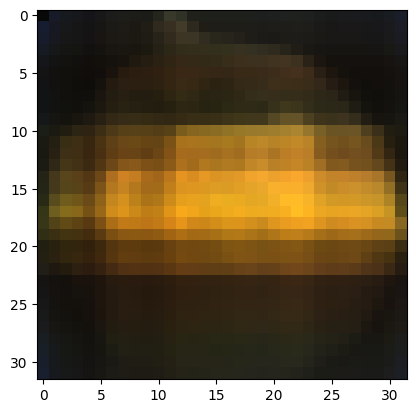

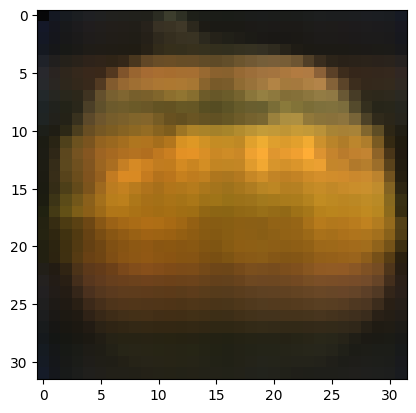

In [ ]:
X_recons = (Q * scaleX * 256).astype(np.int32)

for i in range(len(X_recons)):
    plt.imshow(X_recons[i])
    plt.show()

## MovieLensデータセットによる実験

In [ ]:
! wget https://files.grouplens.org/datasets/movielens/ml-latest-small.zip
! unzip ml-latest-small.zip

--2024-02-01 02:30:49--  https://files.grouplens.org/datasets/movielens/ml-latest-small.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 978202 (955K) [application/zip]
Saving to: ‘ml-latest-small.zip’

ml-latest-small.zip 100%[===================>] 955.28K  --.-KB/s    in 0.1s    

2024-02-01 02:30:50 (6.57 MB/s) - ‘ml-latest-small.zip’ saved [978202/978202]

Archive:  ml-latest-small.zip
   creating: ml-latest-small/
  inflating: ml-latest-small/links.csv  
  inflating: ml-latest-small/tags.csv  
  inflating: ml-latest-small/ratings.csv  
  inflating: ml-latest-small/README.txt  
  inflating: ml-latest-small/movies.csv  


In [ ]:
import pandas as pd

df = pd.read_csv("ml-latest-small/movies.csv")

genres_set = set()
for i, r in df.iterrows():
    for el in r["genres"].split("|"):
        genres_set.add(el)
genres_list = list(genres_set)
genres_list

['Film-Noir',
 'Crime',
 'Romance',
 'War',
 'Documentary',
 'Children',
 'Musical',
 'Fantasy',
 'Drama',
 '(no genres listed)',
 'Adventure',
 'Comedy',
 'Action',
 'Western',
 'Thriller',
 'Sci-Fi',
 'Mystery',
 'Horror',
 'IMAX',
 'Animation']

In [ ]:
edges_mg_dict = {}
mid_dict = {}
for i, r in df.iterrows():
    for el in r["genres"].split("|"):
        genres_set.add(el)
        j = genres_list.index(el)
        m = int(r["movieId"])
        if m not in mid_dict:
            mid_dict[m] = len(mid_dict)
        if mid_dict[m] not in edges_mg_dict:
            edges_mg_dict[mid_dict[m]] = []
        edges_mg_dict[mid_dict[m]].append(j)
edges_mg_dict

{0: [10, 19, 5, 11, 7],
 1: [10, 5, 7],
 2: [11, 2],
 3: [11, 8, 2],
 4: [11],
 5: [12, 1, 14],
 6: [11, 2],
 7: [10, 5],
 8: [12],
 9: [12, 10, 14],
 10: [11, 8, 2],
 11: [11, 17],
 12: [10, 19, 5],
 13: [8],
 14: [12, 10, 2],
 15: [1, 8],
 16: [8, 2],
 17: [11],
 18: [11],
 19: [12, 11, 1, 8, 14],
 20: [11, 1, 14],
 21: [1, 8, 17, 16, 14],
 22: [12, 1, 14],
 23: [8, 15],
 24: [8, 2],
 25: [8],
 26: [5, 8],
 27: [8, 2],
 28: [10, 8, 7, 16, 15],
 29: [1, 8],
 30: [8],
 31: [16, 15, 14],
 32: [5, 8],
 33: [1, 8],
 34: [5, 11],
 35: [11, 2],
 36: [8],
 37: [8, 3],
 38: [12, 1, 8],
 39: [8],
 40: [12, 10, 7],
 41: [11, 8, 14],
 42: [8, 2],
 43: [16, 14],
 44: [19, 5, 8, 6, 2],
 45: [8, 2],
 46: [1, 16, 14],
 47: [11, 8, 2],
 48: [10, 8],
 49: [5, 11],
 50: [8],
 51: [8],
 52: [11, 8, 2],
 53: [10, 5, 7],
 54: [8, 14],
 55: [8],
 56: [11, 1],
 57: [11, 2],
 58: [11],
 59: [12, 15, 14],
 60: [11, 2],
 61: [11],
 62: [12, 11, 17, 14],
 63: [12],
 64: [11, 8],
 65: [8, 3],
 66: [8, 2],
 67: [

In [ ]:
df = pd.read_csv("ml-latest-small/ratings.csv")
edges = []

for i, r in df.iterrows():
    m = int(r["movieId"])
    if m in mid_dict:
        for g in edges_mg_dict[mid_dict[m]]:
            e = (int(r["userId"]) - 1, mid_dict[m], g, r["rating"])
            edges.append(e)
edges

[(0, 0, 10, 4.0),
 (0, 0, 19, 4.0),
 (0, 0, 5, 4.0),
 (0, 0, 11, 4.0),
 (0, 0, 7, 4.0),
 (0, 2, 11, 4.0),
 (0, 2, 2, 4.0),
 (0, 5, 12, 4.0),
 (0, 5, 1, 4.0),
 (0, 5, 14, 4.0),
 (0, 43, 16, 5.0),
 (0, 43, 14, 5.0),
 (0, 46, 1, 5.0),
 (0, 46, 16, 5.0),
 (0, 46, 14, 5.0),
 (0, 62, 12, 3.0),
 (0, 62, 11, 3.0),
 (0, 62, 17, 3.0),
 (0, 62, 14, 3.0),
 (0, 89, 10, 5.0),
 (0, 89, 11, 5.0),
 (0, 89, 1, 5.0),
 (0, 89, 2, 5.0),
 (0, 97, 12, 4.0),
 (0, 97, 8, 4.0),
 (0, 97, 3, 4.0),
 (0, 124, 12, 5.0),
 (0, 124, 8, 5.0),
 (0, 124, 2, 5.0),
 (0, 124, 3, 5.0),
 (0, 130, 11, 5.0),
 (0, 130, 3, 5.0),
 (0, 136, 12, 5.0),
 (0, 136, 2, 5.0),
 (0, 136, 13, 5.0),
 (0, 184, 11, 5.0),
 (0, 190, 11, 3.0),
 (0, 197, 10, 5.0),
 (0, 197, 11, 5.0),
 (0, 201, 11, 4.0),
 (0, 201, 8, 4.0),
 (0, 224, 12, 5.0),
 (0, 224, 10, 5.0),
 (0, 224, 15, 5.0),
 (0, 257, 11, 3.0),
 (0, 257, 1, 3.0),
 (0, 257, 8, 3.0),
 (0, 257, 14, 3.0),
 (0, 275, 12, 3.0),
 (0, 275, 10, 3.0),
 (0, 275, 15, 3.0),
 (0, 291, 11, 5.0),
 (0, 307, 12,

In [ ]:
u_max = max([e[0] for e in edges])
m_max = max([e[1] for e in edges])
g_max = max([e[2] for e in edges])

print(u_max, m_max, g_max)

609 9741 19


In [ ]:
import numpy as np

M = np.zeros((u_max + 1, m_max + 1, g_max + 1))
for u, m, g, r in edges:
    M[u, m, g] = r

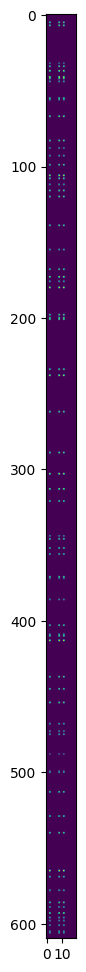

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(24, 12))
plt.imshow(M[:, 10, :])

In [ ]:
M_ = M[:10, :10, :]

In [ ]:
M_.shape

(10, 10, 20)

In [ ]:
print(M_.shape)
all_history_kl, scaleX, Q, Hq = MBTA(M_, order=2, eps=1.0e-10)

(10, 10, 20)
iter= 0 kl= 3.8130742758478187 mse= 1.1246060288774924e-05
iter= 1 kl= 5.184432773086199 mse= 9.322595243683393e-05
iter= 2 kl= 18.835238382328598 mse= 0.0004940033489383291


In [ ]:
from scipy.special import logsumexp

logsumexp([1, 2, 3])

3.4076059644443806